<a href="https://colab.research.google.com/github/eschwarzbeckf/taxi/blob/main/taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Setup

In [1]:
!git clone https://github.com/eschwarzbeckf/taxi.git
%cd taxi
!pip install -r requirements.txt

fatal: destination path 'taxi' already exists and is not an empty directory.
/content/taxi


# 1 Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import os

# 2 Code

## DDQN w Priority

### Functions and Classes

In [3]:
class QNetwork(nn.Module):
    """
    Q-Network with an Embedding layer for discrete state spaces.
    This is more efficient than one-hot encoding for large state spaces.
    """
    def __init__(self, state_size, action_size, embedding_dim=32, hidden_dim=64):
        super(QNetwork, self).__init__()
        self.state_size = state_size
        self.action_size = action_size

        # Embedding layer to convert integer states into dense vectors
        self.embedding = nn.Embedding(state_size, embedding_dim)

        # The rest of the network processes the embedded state vector
        self.model = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_size)
        )

    def forward(self, state):
        """
        Forward pass through the network.
        Handles both single states (during action selection) and batches of states (during training).
        """
        # Ensure state is a LongTensor for the embedding layer
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.long)
        elif state.dtype != torch.long:
            state = state.long()

        # Pass the state through the embedding layer
        embedded_state = self.embedding(state)

        # Pass the embedded state through the rest of the model
        return self.model(embedded_state)

In [4]:
def select_action(q_values, start, end, decay, step):
    """
    Selects an action using an epsilon-greedy policy.
    """
    epsilon = end + (start - end) * np.exp(-step / decay)

    if random.random() < epsilon:
        # Exploration: choose a random action
        return random.choice(range(len(q_values)))
    else:
        # Exploitation: choose the best action
        return torch.argmax(q_values).item()

In [5]:
class PrioritizedReplayBuffer:
    """
    A prioritized experience replay buffer.
    Experiences with higher TD-error are more likely to be sampled.
    """
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001, epsilon=0.01):
        self.memory = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
        self.alpha = alpha
        self.beta = beta
        self.beta_increment = beta_increment
        self.epsilon = epsilon
        self.capacity = capacity

    def push(self, state, action, reward, next_state, done):
        """Adds an experience to the buffer with maximum priority."""
        experience = (state, action, reward, next_state, done)
        max_priority = max(self.priorities) if self.memory else 1.0

        self.memory.append(experience)
        self.priorities.append(max_priority)

    def __len__(self):
        return len(self.memory)

    def update_priorities(self, indices, td_errors):
        """Updates the priorities of sampled experiences."""
        for idx, td_error in zip(indices, td_errors):
            # Use detached tensor value for priority
            priority = abs(td_error.item()) + self.epsilon
            self.priorities[idx] = priority

    def increase_beta(self):
        """Anneals beta towards 1.0."""
        self.beta = min(1.0, self.beta + self.beta_increment)

    def sample(self, batch_size):
        """Samples a batch of experiences from the buffer."""
        priorities_np = np.array(self.priorities)
        # Calculate sampling probabilities based on priorities
        probabilities = priorities_np ** self.alpha
        probabilities /= np.sum(probabilities)

        # Draw indices for the sample
        indices = np.random.choice(len(self.memory), batch_size, p=probabilities)

        # Get the experiences for the chosen indices
        experiences = [self.memory[i] for i in indices]

        # Calculate importance sampling weights
        total_samples = len(self.memory)
        sampled_probs = probabilities[indices]
        weights = (total_samples * sampled_probs) ** -self.beta
        weights /= np.max(weights) # Normalize for stability

        # Unzip experiences and convert to tensors
        states, actions, rewards, next_states, dones = zip(*experiences)

        # States and actions should be LongTensors for embedding/gathering
        states_tensor = torch.tensor(states, dtype=torch.long)
        actions_tensor = torch.tensor(actions, dtype=torch.long).unsqueeze(1)

        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        next_states_tensor = torch.tensor(next_states, dtype=torch.long)
        dones_tensor = torch.tensor(dones, dtype=torch.float32)
        weights_tensor = torch.tensor(weights, dtype=torch.float32)

        return (states_tensor, actions_tensor, rewards_tensor, next_states_tensor,
                dones_tensor, indices, weights_tensor)

In [6]:
def update_target_network(target_network, primary_network, tau):
    """
    Performs a soft update of the target network's weights.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    """
    target_net_state_dict = target_network.state_dict()
    primary_net_state_dict = primary_network.state_dict()
    for key in primary_net_state_dict:
        target_net_state_dict[key] = primary_net_state_dict[key] * tau + target_net_state_dict[key] * (1 - tau)
    target_network.load_state_dict(target_net_state_dict)

In [7]:
env = gym.make('Taxi-v3')
# env = gym.wrappers.RecordVideo(env, video_folder="./video_directory")
state_size = env.observation_space.n
action_size = env.action_space.n

In [8]:
env.observation_space.n

np.int64(500)

In [9]:
primary_network = QNetwork(1, action_size)

### Training

In [10]:
EMBEDDING_DIM = 32
HIDDEN_DIM = 128
LEARNING_RATE = 0.001
BUFFER_CAPACITY = 10_000
BATCH_SIZE = 64
GAMMA = 0.99  # Discount factor
TAU = 0.005   # For soft update of target network
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 500 # Slower decay rate
NUM_EPISODES = 1500

primary_network = QNetwork(state_size, action_size, EMBEDDING_DIM, HIDDEN_DIM)
target_network = QNetwork(state_size, action_size, EMBEDDING_DIM, HIDDEN_DIM)
target_network.load_state_dict(primary_network.state_dict()) # Initialize target with same weights
optimizer = torch.optim.Adam(primary_network.parameters(), lr=LEARNING_RATE)
replay_buffer = PrioritizedReplayBuffer(capacity=BUFFER_CAPACITY)

all_episode_rewards_ddqn = []
epsilon_values_ddqn = []

for episode in range(NUM_EPISODES):
    state, info = env.reset()
    done = False
    current_episode_reward = 0

    replay_buffer.increase_beta() # Anneal beta at the start of each episode

    while not done:
        # Select action
        with torch.no_grad():
            q_values = primary_network(state)
        action = select_action(q_values.squeeze(), EPSILON_START, EPSILON_END, EPSILON_DECAY, episode)
        epsilon_values_ddqn.append(EPSILON_END + (EPSILON_START - EPSILON_END) * np.exp(-episode / EPSILON_DECAY))

        # Take action in environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        current_episode_reward += reward

        # Store experience in replay buffer
        replay_buffer.push(state, action, reward, next_state, done)

        # --- Learning Step ---
        if len(replay_buffer) >= BATCH_SIZE:
            # Sample a batch from the buffer
            states, actions, rewards, next_states, dones, indices, weights = replay_buffer.sample(BATCH_SIZE)

            # --- Calculate TD Target using Double DQN principle ---
            with torch.no_grad():
                # 1. Get the best action from the primary network for the next states
                next_actions = primary_network(next_states).argmax(1).unsqueeze(1)
                # 2. Get the Q-value for that action from the target network
                next_q_values = target_network(next_states).gather(1, next_actions).squeeze(1)
                # 3. Compute the TD target
                target_q_values = rewards + GAMMA * next_q_values * (1 - dones)

            # --- Calculate current Q-values ---
            # Get Q-values from the primary network for the actions that were actually taken
            current_q_values = primary_network(states).gather(1, actions).squeeze(1)

            # --- Update Priorities and Calculate Loss ---
            td_errors = target_q_values - current_q_values
            replay_buffer.update_priorities(indices, td_errors)

            # Calculate weighted MSE loss
            loss = (weights * F.mse_loss(current_q_values, target_q_values, reduction='none')).mean()

            # --- Gradient Descent ---
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(primary_network.parameters(), 1.0) # Clip gradients for stability
            optimizer.step()

            # --- Soft Update Target Network ---
            update_target_network(target_network, primary_network, TAU)

        state = next_state

    all_episode_rewards_ddqn.append(current_episode_reward)

    # Print progress
    if done:
      last_100_avg = np.mean(all_episode_rewards_ddqn[-100:])
      print(f"Episode: {episode+1}/{NUM_EPISODES} | Reward: {current_episode_reward} | Avg Reward (Last 100): {last_100_avg:.2f} | Epsilon: {epsilon_values_ddqn[-1]:.3f}")

env.close()

Episode: 1/1500 | Reward: -920 | Avg Reward (Last 100): -920.00 | Epsilon: 1.000
Episode: 2/1500 | Reward: -731 | Avg Reward (Last 100): -825.50 | Epsilon: 0.998
Episode: 3/1500 | Reward: -830 | Avg Reward (Last 100): -827.00 | Epsilon: 0.996
Episode: 4/1500 | Reward: -677 | Avg Reward (Last 100): -789.50 | Epsilon: 0.994
Episode: 5/1500 | Reward: -192 | Avg Reward (Last 100): -670.00 | Epsilon: 0.992
Episode: 6/1500 | Reward: -749 | Avg Reward (Last 100): -683.17 | Epsilon: 0.990
Episode: 7/1500 | Reward: -821 | Avg Reward (Last 100): -702.86 | Epsilon: 0.988
Episode: 8/1500 | Reward: -785 | Avg Reward (Last 100): -713.12 | Epsilon: 0.986
Episode: 9/1500 | Reward: -794 | Avg Reward (Last 100): -722.11 | Epsilon: 0.984
Episode: 10/1500 | Reward: -695 | Avg Reward (Last 100): -719.40 | Epsilon: 0.982
Episode: 11/1500 | Reward: -839 | Avg Reward (Last 100): -730.27 | Epsilon: 0.980
Episode: 12/1500 | Reward: -632 | Avg Reward (Last 100): -722.08 | Epsilon: 0.978
Episode: 13/1500 | Reward

### Plot Results

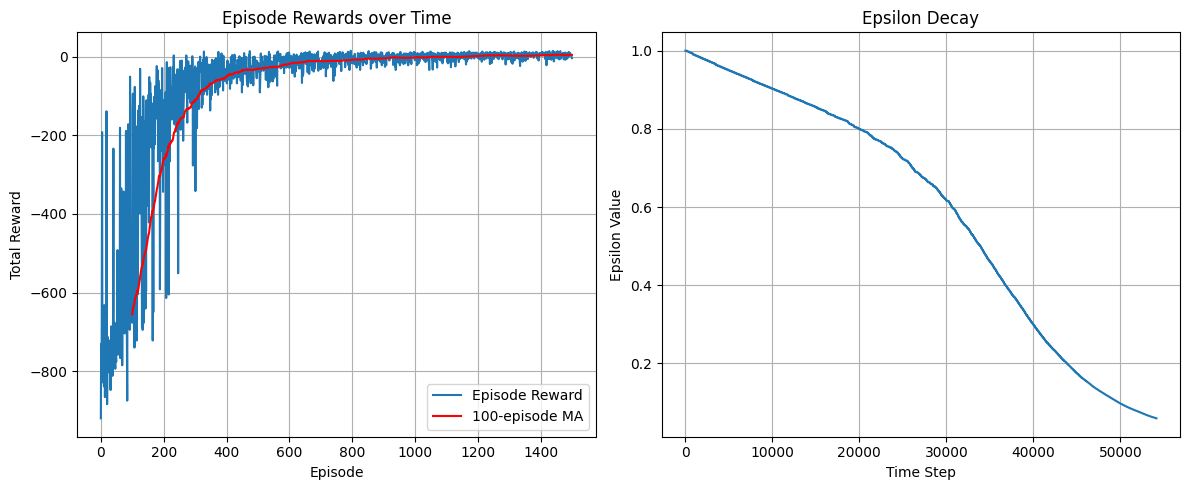

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(all_episode_rewards_ddqn, label='Episode Reward')
# Calculate and plot a moving average
moving_avg = np.convolve(all_episode_rewards_ddqn, np.ones(100)/100, mode='valid')
plt.plot(range(99, len(all_episode_rewards_ddqn)), moving_avg, label='100-episode MA', color='red')
plt.title('Episode Rewards over Time')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epsilon_values_ddqn)
plt.title('Epsilon Decay')
plt.xlabel('Time Step')
plt.ylabel('Epsilon Value')
plt.grid(True)

plt.tight_layout()
plt.show()

### Video Evaluation

In [12]:
# Create a new environment for recording
# The render_mode='rgb_array' is required for the video recorder.
video_env = gym.make('Taxi-v3', render_mode='rgb_array')
video_folder = './video_directory'
if not os.path.exists(video_folder):
    os.makedirs(video_folder)

# Wrap the environment to record a video
# The 'episode_trigger' will save a video for the specified episodes.
# Here, we record the first 10 episodes of the evaluation run.
video_env = gym.wrappers.RecordVideo(video_env, video_folder=video_folder,name_prefix='ddqn_wprio', episode_trigger=lambda e: e < 10)

# Set the network to evaluation mode
target_network.eval()

for episode in range(10):
    state, info = video_env.reset()
    done = False
    total_reward = 0
    while not done:
        # No exploration, always choose the best action
        with torch.no_grad():
            q_values = target_network(state)
        action = torch.argmax(q_values).item()

        # Take action in the environment
        state, reward, terminated, truncated, _ = video_env.step(action)
        done = terminated or truncated
        total_reward += reward

    print(f"Evaluation Episode: {episode + 1}, Total Reward: {total_reward}")

video_env.close()
print(f"Finished evaluation. Videos saved in '{video_folder}' folder.")

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/taxi/video_directory folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Evaluation Episode: 1, Total Reward: 4
Evaluation Episode: 2, Total Reward: 10
Evaluation Episode: 3, Total Reward: 8
Evaluation Episode: 4, Total Reward: 8
Evaluation Episode: 5, Total Reward: 13
Evaluation Episode: 6, Total Reward: 7
Evaluation Episode: 7, Total Reward: 10
Evaluation Episode: 8, Total Reward: 10
Evaluation Episode: 9, Total Reward: 11
Evaluation Episode: 10, Total Reward: 8
Finished evaluation. Videos saved in './video_directory' folder.


## Table based Q

### Functions and Classes

In [13]:
def select_action(q_table,state, start, end, decay, step):
    """
    Selects an action using an epsilon-greedy policy.
    """
    epsilon = end + (start - end) * np.exp(-step / decay)

    if random.random() < epsilon:
        # Exploration: choose a random action
        return random.choice(range(q_table.shape[1]))
    else:
        # Exploitation: choose the best action
        return np.argmax(q_table[state])

### Training

In [27]:
LEARNING_RATE = 0.7
GAMMA = 0.99  # Discount factor
EPSILON_START = 1.0
EPSILON_END = 0.001
EPSILON_DECAY = 1200 # Slower decay rate
NUM_EPISODES = 3500


all_episode_rewards_qtable = []
epsilon_values_qtable = []

q_table = np.zeros((state_size, action_size))
for episode in range(NUM_EPISODES):
  state, info = env.reset()
  done = False
  current_episode_reward = 0
  step = 0
  while not done:
    action = select_action(q_table,state,EPSILON_START, EPSILON_END, EPSILON_DECAY, episode)
    epsilon_values_qtable.append(EPSILON_END + (EPSILON_START - EPSILON_END) * np.exp(-episode / EPSILON_DECAY))
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    q_table[state,action] = q_table[state,action] + LEARNING_RATE * (reward + GAMMA * np.max(q_table[next_state,:])-q_table[state,action])
    current_episode_reward += reward
    state = next_state

    if done:
      all_episode_rewards_qtable.append(current_episode_reward)
      last_100_avg = np.mean(all_episode_rewards_qtable[-100:])
      print(f"Episode: {episode+1}/{NUM_EPISODES} | Reward: {current_episode_reward} | Avg Reward (Last 100): {last_100_avg:.2f} | Epsilon: {epsilon_values_qtable[-1]:.3f}")



Episode: 1/3500 | Reward: -749 | Avg Reward (Last 100): -749.00 | Epsilon: 1.000
Episode: 2/3500 | Reward: -758 | Avg Reward (Last 100): -753.50 | Epsilon: 0.999
Episode: 3/3500 | Reward: -839 | Avg Reward (Last 100): -782.00 | Epsilon: 0.998
Episode: 4/3500 | Reward: -749 | Avg Reward (Last 100): -773.75 | Epsilon: 0.998
Episode: 5/3500 | Reward: -758 | Avg Reward (Last 100): -770.60 | Epsilon: 0.997
Episode: 6/3500 | Reward: -821 | Avg Reward (Last 100): -779.00 | Epsilon: 0.996
Episode: 7/3500 | Reward: -749 | Avg Reward (Last 100): -774.71 | Epsilon: 0.995
Episode: 8/3500 | Reward: -785 | Avg Reward (Last 100): -776.00 | Epsilon: 0.994
Episode: 9/3500 | Reward: -695 | Avg Reward (Last 100): -767.00 | Epsilon: 0.993
Episode: 10/3500 | Reward: -857 | Avg Reward (Last 100): -776.00 | Epsilon: 0.993
Episode: 11/3500 | Reward: -803 | Avg Reward (Last 100): -778.45 | Epsilon: 0.992
Episode: 12/3500 | Reward: -558 | Avg Reward (Last 100): -760.08 | Epsilon: 0.991
Episode: 13/3500 | Reward

### Plot Results

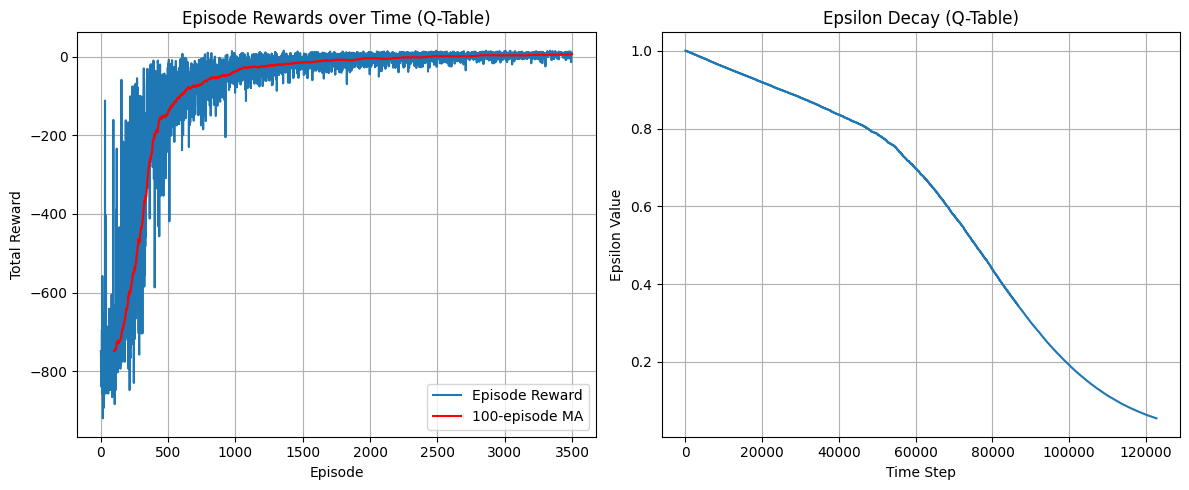

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(all_episode_rewards_qtable, label='Episode Reward')
# Calculate and plot a moving average
moving_avg = np.convolve(all_episode_rewards_qtable, np.ones(100)/100, mode='valid')
plt.plot(range(99, len(all_episode_rewards_qtable)), moving_avg, label='100-episode MA', color='red')
plt.title('Episode Rewards over Time (Q-Table)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epsilon_values_qtable)
plt.title('Epsilon Decay (Q-Table)')
plt.xlabel('Time Step')
plt.ylabel('Epsilon Value')
plt.grid(True)

plt.tight_layout()
plt.show()

### Video Evaluation

In [36]:
# Create a new environment for recording
# The render_mode='rgb_array' is required for the video recorder.
video_env = gym.make('Taxi-v3', render_mode='rgb_array')
video_folder = './video_directory'

# Wrap the environment to record a video
# The 'episode_trigger' will save a video for the specified episodes.
# Here, we record the first 10 episodes of the evaluation run.
video_env = gym.wrappers.RecordVideo(video_env, video_folder=video_folder,name_prefix='qtable', episode_trigger=lambda e: e < 10)

for episode in range(10):
    state, info = video_env.reset()
    done = False
    total_reward = 0
    while not done:
        # No exploration, always choose the best action
        action = np.argmax(q_table[state])

        # Take action in the environment
        state, reward, terminated, truncated, _ = video_env.step(action)
        done = terminated or truncated
        total_reward += reward

    print(f"Evaluation Episode: {episode + 1}, Total Reward: {total_reward}")

video_env.close()

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/taxi/video_directory folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Evaluation Episode: 1, Total Reward: 6
Evaluation Episode: 2, Total Reward: 9
Evaluation Episode: 3, Total Reward: 8
Evaluation Episode: 4, Total Reward: 10
Evaluation Episode: 5, Total Reward: 5
Evaluation Episode: 6, Total Reward: 7
Evaluation Episode: 7, Total Reward: 10
Evaluation Episode: 8, Total Reward: 5
Evaluation Episode: 9, Total Reward: 4
Evaluation Episode: 10, Total Reward: 10


## Results Comparison

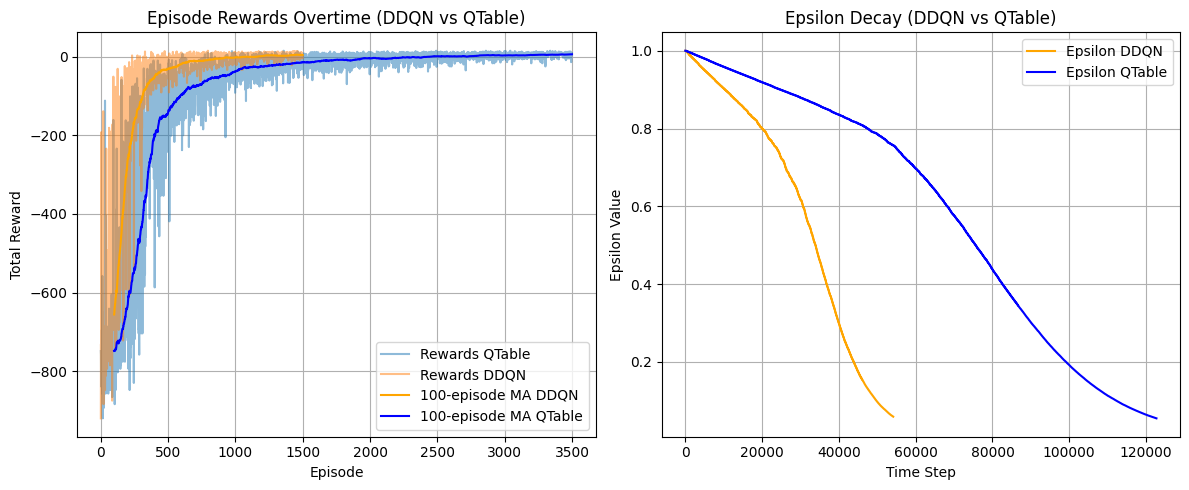

In [37]:
moving_avg_ddqn = np.convolve(all_episode_rewards_ddqn, np.ones(100)/100, mode='valid')
moving_avg_qtable = np.convolve(all_episode_rewards_qtable, np.ones(100)/100, mode='valid')
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].set_title("Episode Rewards Overtime (DDQN vs QTable)")
ax[0].plot(all_episode_rewards_qtable, label='Rewards QTable', alpha=0.5)
ax[0].plot(all_episode_rewards_ddqn, label='Rewards DDQN', alpha=0.5)
ax[0].plot(range(99, len(all_episode_rewards_ddqn)), moving_avg_ddqn, label='100-episode MA DDQN', color='orange')
ax[0].plot(range(99, len(all_episode_rewards_qtable)), moving_avg_qtable, label='100-episode MA QTable', color='blue')
ax[0].grid(True)
ax[0].legend()
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Total Reward')

ax[1].set_title('Epsilon Decay (DDQN vs QTable)')
ax[1].set_xlabel('Time Step')
ax[1].set_ylabel('Epsilon Value')
ax[1].plot(epsilon_values_ddqn, label='Epsilon DDQN', color='orange')
ax[1].plot(epsilon_values_qtable, label='Epsilon QTable', color='b')
ax[1].grid(True)
ax[1].legend()
plt.tight_layout()
plt.show()